In [271]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
from scipy.optimize import least_squares


In [177]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [178]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [179]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


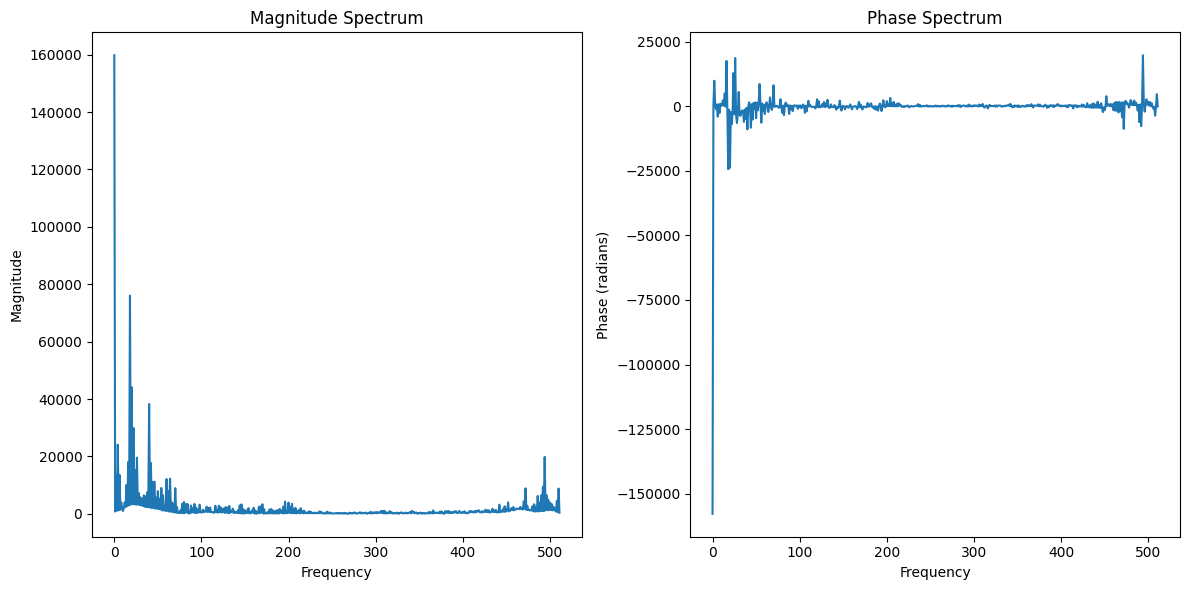

In [180]:
complex_range_profiles = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitudes = [np.abs(complex_range_profile) for complex_range_profile in complex_range_profiles]
angles = [np.angle(complex_range_profile) for complex_range_profile in complex_range_profiles]
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(magnitudes[0])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')

plt.subplot(122)
plt.plot(complex_range_profiles[0])
plt.xlabel('Frequency')
plt.ylabel('Phase (radians)')
plt.title('Phase Spectrum')

plt.tight_layout()

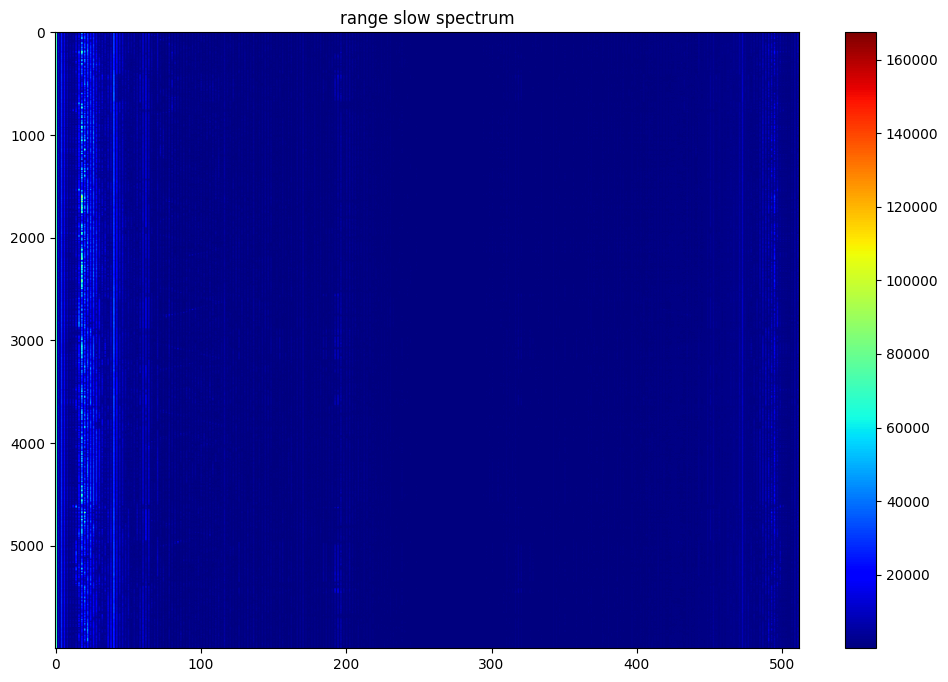

In [181]:
# range-slow time matrix
range_slow_time_m_x_n = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
range_slow_time_m_x_n_spectrum = [np.abs(profile) for profile in range_slow_time_m_x_n]
plt.figure(figsize=(12,8))
plt.imshow(range_slow_time_m_x_n_spectrum,cmap='jet',aspect='auto')
plt.colorbar()
plt.title("range slow spectrum")
plt.show()

In [182]:
# calculate DC 
corrected_range_slow_time_m_x_n = np.empty(shape=np.array(range_slow_time_m_x_n).shape, dtype=complex)
range_bins=np.array(range_slow_time_m_x_n).shape[1]
DC_ranges=  np.empty(range_bins, dtype='object')
for r_th in range(0,range_bins):
    
    range_bin_r_th =np.array(range_slow_time_m_x_n)[:,r_th]
    avg_re_I= np.mean(np.real(range_bin_r_th))
    avg_im_Q= np.mean(np.imag(range_bin_r_th))
    DC_ranges[r_th]=avg_re_I +  avg_im_Q*1j


In [286]:

def residuals(params, x1, x2):
    a, b, c = params
    return (x1 - a)**2 + (x2 - b)**2 - c

initial_params=np.array([0.5,0.5,0.5])
results =[] 
for i_th in range(0,range_bins):
    range_slow_ith=np.array(range_slow_time_m_x_n)[:,i_th]
    reals = [rsith.real for rsith in range_slow_ith]
    imags = [rsith.imag for rsith in range_slow_ith]
    result = least_squares(residuals, initial_params, args=(reals, imags))
    results.append(result)
    print("done range: ",i_th)
    



done range:  0
done range:  1
done range:  2
done range:  3
done range:  4
done range:  5
done range:  6
done range:  7
done range:  8
done range:  9
done range:  10
done range:  11
done range:  12
done range:  13
done range:  14
done range:  15
done range:  16
done range:  17
done range:  18
done range:  19
done range:  20
done range:  21
done range:  22
done range:  23
done range:  24
done range:  25
done range:  26
done range:  27
done range:  28
done range:  29
done range:  30
done range:  31
done range:  32
done range:  33
done range:  34
done range:  35
done range:  36
done range:  37
done range:  38
done range:  39
done range:  40
done range:  41
done range:  42
done range:  43
done range:  44
done range:  45
done range:  46
done range:  47
done range:  48
done range:  49
done range:  50
done range:  51
done range:  52
done range:  53
done range:  54
done range:  55
done range:  56
done range:  57
done range:  58
done range:  59
done range:  60
done range:  61
done range:  62
do

In [343]:
print(results[0].x)

new_DC_corrected_range_slow_time_m_x_n = np.empty(shape=np.array(range_slow_time_m_x_n).shape, dtype=complex)
for i_th in range(0,range_bins):
    a,b,c =results[0].x
    DC_point =a+b*1j 
    new_DC_corrected_range_slow_time_m_x_n[:,i_th] = np.array(range_slow_time_m_x_n)[:,i_th] - DC_point


[-159894.68366795  -26375.0035076   328230.33263403]


In [360]:
print(results[0])
real_parts = []
imag_parts = []

for range_i in range_slow_time_m_x_n:
    real_parts.append(range_i.real)
    imag_parts.append(range_i.imag)
    
r_result = least_squares(residuals, initial_params, args=(np.array(real_parts).flatten(), (np.array(imag_parts).flatten())))


     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 6.342e+06  2.000e+06 ...  4.401e+05  1.107e+06]
           x: [-1.599e+05 -2.638e+04  3.282e+05]
        cost: 7.112893950015595e+16
         jac: [[-4.121e+03 -3.114e+03 -1.000e+00]
               [-1.869e+03 -2.412e+03 -1.000e+00]
               ...
               [-9.614e+02  1.466e+03 -1.000e+00]
               [-2.071e+03  1.204e+03 -1.000e+00]]
        grad: [ 3.158e+10 -2.193e+10 -1.878e+10]
  optimality: 31584432044.918945
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 300
        njev: 294


In [362]:
print(r_result.x)
a,b,c =r_result.x
global_dc  =a+b*1j 
row_DC_range_slow_time_m_x_n = np.empty(shape=np.array(range_slow_time_m_x_n).shape, dtype=complex)
for i,range_i in enumerate(range_slow_time_m_x_n):
    row_DC_range_slow_time_m_x_n[i]  = range_i - global_dc

[-16993.92041075  -3341.99751217  12938.41168541]


In [344]:
#DC correction
for i_th in range(0,range_bins):
    DC=DC_ranges[i_th]    
    corrected_range_slow_time_m_x_n[:,i_th] = np.array(range_slow_time_m_x_n)[:,i_th] -DC
    

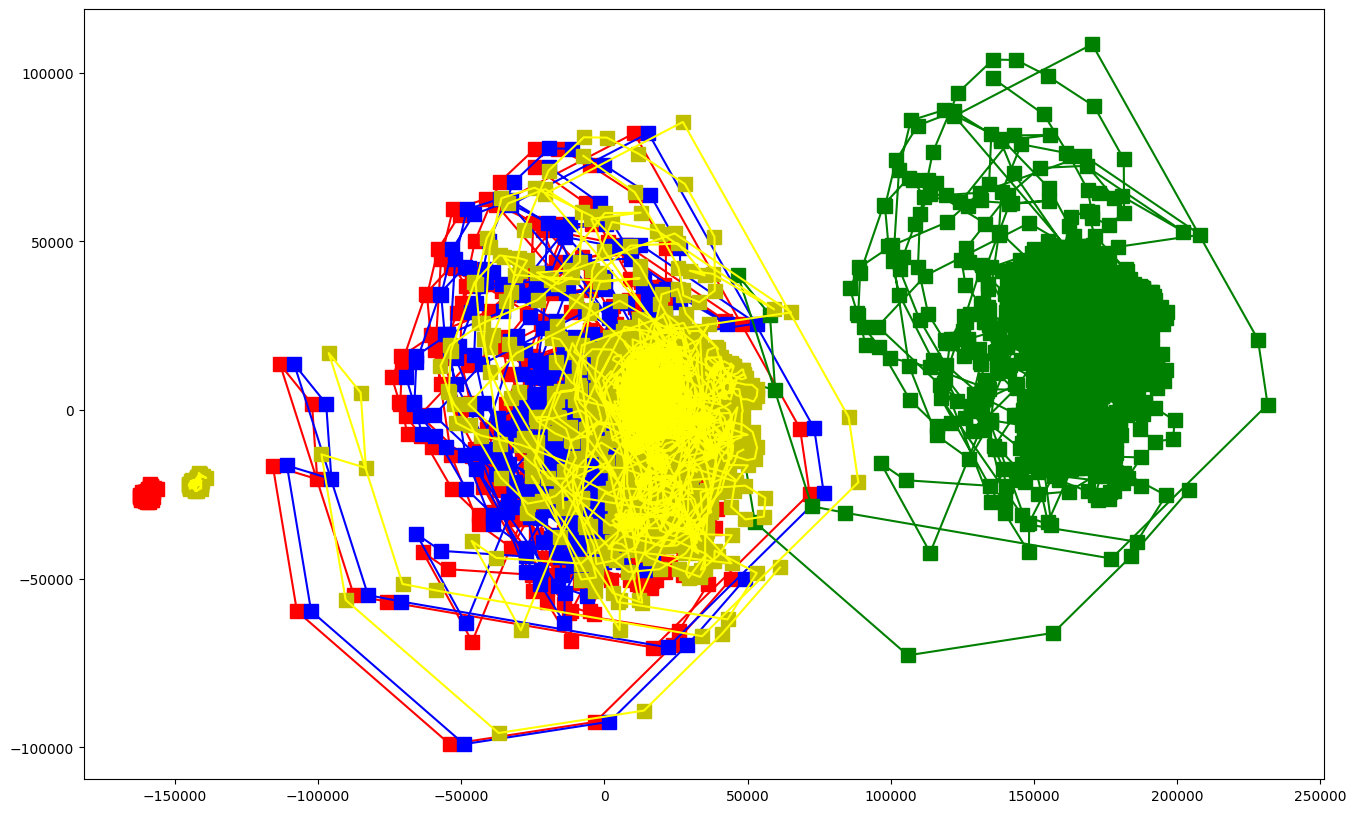

In [365]:
tmp_org_range_slow_time_m_x_n =range_slow_time_m_x_n[0:200]
DC_real_parts = [z.real for z in tmp_org_range_slow_time_m_x_n]
DC_imaginary_parts = [z.imag for z in tmp_org_range_slow_time_m_x_n]

tmp_range_slow_time_m_x_n =corrected_range_slow_time_m_x_n[0:200]
DC_corrected_real_parts = [sl.real for sl in tmp_range_slow_time_m_x_n]
DC_corrected_imaginary_parts = [sl.imag for sl in tmp_range_slow_time_m_x_n]



tmp_new_DC_corrected_range_slow_time_m_x_n =new_DC_corrected_range_slow_time_m_x_n[0:200]
new_DC_corrected_range_slow_time_m_x_n_real =[sl.real for sl in tmp_new_DC_corrected_range_slow_time_m_x_n]
new_DC_corrected_range_slow_time_m_x_n_image = [sl.imag for sl in tmp_new_DC_corrected_range_slow_time_m_x_n]

tmp_row_DC_range_slow_time_m_x_n =row_DC_range_slow_time_m_x_n[0:200]
row_DC_range_slow_time_m_x_n_real =[sl.real for sl in tmp_row_DC_range_slow_time_m_x_n]
row_DC_range_slow_time_m_x_n_image =[sl.imag for sl in tmp_row_DC_range_slow_time_m_x_n]

plt.figure(figsize=(16, 10))

plt.plot(DC_real_parts, DC_imaginary_parts, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_real_parts, DC_imaginary_parts, color='red')

plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, color='blue')


plt.plot(new_DC_corrected_range_slow_time_m_x_n_real, new_DC_corrected_range_slow_time_m_x_n_image, 'gs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(new_DC_corrected_range_slow_time_m_x_n_real, new_DC_corrected_range_slow_time_m_x_n_image, color='green')



plt.plot(row_DC_range_slow_time_m_x_n_real, row_DC_range_slow_time_m_x_n_image, 'ys-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(row_DC_range_slow_time_m_x_n_real, row_DC_range_slow_time_m_x_n_image, color='yellow')

plt.show()


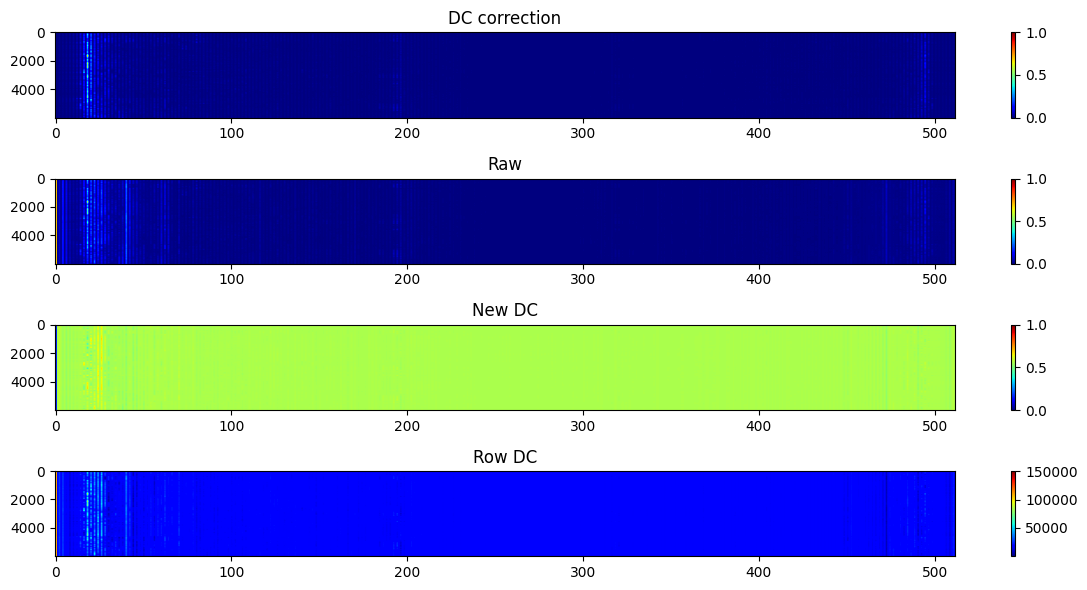

In [366]:
magnitude_corrected_ffts = [np.abs(corrected_fft) for corrected_fft in corrected_range_slow_time_m_x_n]
magnitude_org_ffts = [np.abs(org) for org in range_slow_time_m_x_n]
magnitude_new_dc_fft =[np.abs(new_fft) for new_fft in new_DC_corrected_range_slow_time_m_x_n]
magnitude_row_dc_fft =[np.abs(row_dc) for row_dc in row_DC_range_slow_time_m_x_n]

normalized_correct = (magnitude_corrected_ffts - np.min(magnitude_corrected_ffts)) / (np.max(magnitude_corrected_ffts) - np.min(magnitude_corrected_ffts))
normalized_org = (magnitude_org_ffts - np.min(magnitude_org_ffts)) / (np.max(magnitude_org_ffts) - np.min(magnitude_org_ffts))
normalized_magnitude_new_dc_fft=(magnitude_new_dc_fft - np.min(magnitude_new_dc_fft)) / (np.max(magnitude_new_dc_fft) - np.min(magnitude_new_dc_fft))



plt.figure(figsize=(12, 6))

plt.subplot(4,1,1)
plt.imshow(normalized_correct, cmap='jet', aspect='auto')
plt.colorbar()
plt.title("DC correction")

plt.subplot(4,1,2)
plt.imshow(normalized_org, cmap='jet', aspect='auto')
plt.title("Raw")
plt.colorbar()

plt.subplot(4,1,3)
plt.imshow(normalized_magnitude_new_dc_fft, cmap='jet', aspect='auto')
plt.title("New DC")
plt.colorbar()

plt.subplot(4,1,4)
plt.imshow(magnitude_row_dc_fft, cmap='jet', aspect='auto')
plt.title("Row DC")
plt.colorbar()


plt.tight_layout()

plt.show()

18
18
18
18


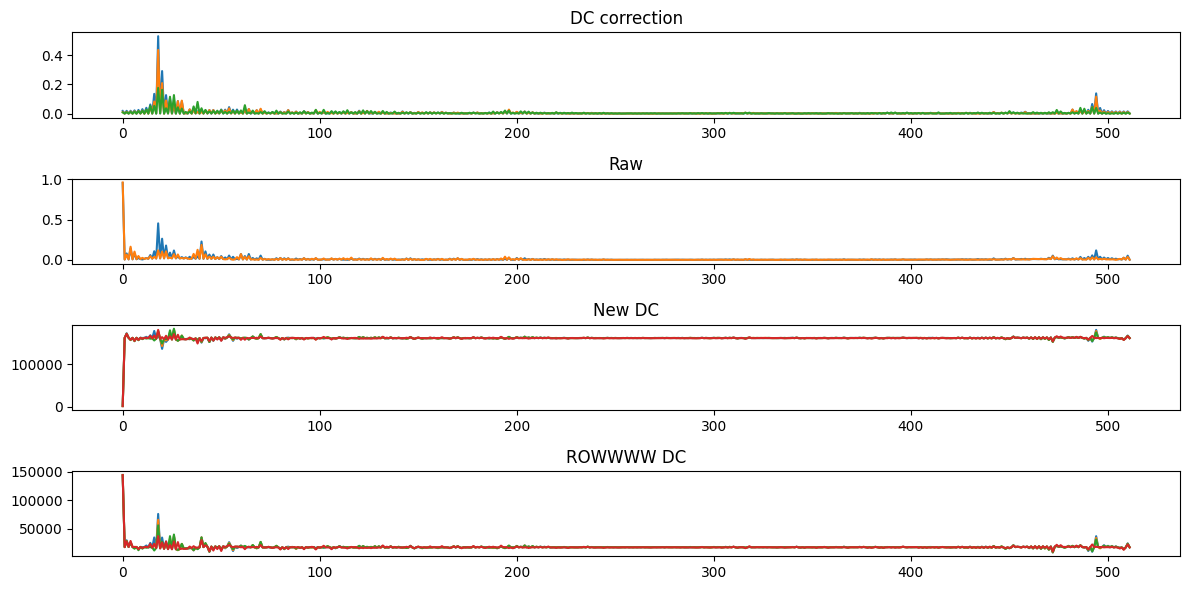

In [372]:
plt.figure(figsize=(12, 6))
plt.subplot(4,1,1)
plt.title("DC correction")
plt.plot(normalized_correct[0])
plt.plot(normalized_correct[1])
plt.plot(normalized_correct[-1])
print(np.argmax(normalized_correct[0]))
print(np.argmax(normalized_correct[1]))
print(np.argmax(normalized_correct[1456]))
print(np.argmax(normalized_correct[-1]))

plt.subplot(4,1,2)
plt.title("Raw")
plt.plot(normalized_org[0])
plt.plot(normalized_org[-1])

plt.subplot(4,1,3)
plt.title("New DC")
plt.plot(magnitude_new_dc_fft[0])
plt.plot(magnitude_new_dc_fft[1])
plt.plot(magnitude_new_dc_fft[2])
plt.plot(magnitude_new_dc_fft[-1])


plt.subplot(4,1,4)
plt.title("ROWWWW DC")
plt.plot(magnitude_row_dc_fft[0])
plt.plot(magnitude_row_dc_fft[1])
plt.plot(magnitude_row_dc_fft[2])
plt.plot(magnitude_row_dc_fft[-1])



plt.tight_layout()
plt.show()



In [349]:
new_magnitude_index = np.zeros(shape=len(magnitude_new_dc_fft))
for  new_magnitude_spectrum in magnitude_new_dc_fft:
    magnitude = np.abs(new_magnitude_spectrum)
    max_index=np.argmax(new_magnitude_spectrum[0:-1])
    
    new_magnitude_index[max_index]+=1
max_bin = max(new_magnitude_index)
bin_of_interest = np.where(max_bin ==new_magnitude_index )[0]

for i,val in enumerate(new_magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",bin_of_interest)

index: 2  :  1.0
index: 12  :  2.0
index: 14  :  65.0
index: 16  :  381.0
index: 18  :  1208.0
index: 20  :  720.0
index: 22  :  358.0
index: 24  :  1143.0
index: 26  :  2081.0
index: 28  :  21.0
index: 34  :  3.0
index: 72  :  1.0
index: 78  :  1.0
index: 84  :  1.0
index: 494  :  13.0
index: 496  :  1.0
bin of interest:  [26]


In [377]:
row_magnitude_index = np.zeros(shape=len(magnitude_row_dc_fft))
for  row_magnitude_spectrum in magnitude_row_dc_fft:
    magnitude = np.abs(row_magnitude_spectrum)
    max_index=np.argmax(row_magnitude_spectrum[1:-1])+1
    
    row_magnitude_index[max_index]+=1
max_bin = max(row_magnitude_index)
bin_of_interest = np.where(max_bin ==row_magnitude_index )[0]

for i,val in enumerate(row_magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",bin_of_interest)

index: 12  :  1.0
index: 14  :  62.0
index: 16  :  352.0
index: 18  :  2345.0
index: 20  :  885.0
index: 22  :  566.0
index: 24  :  770.0
index: 26  :  936.0
index: 28  :  11.0
index: 40  :  68.0
index: 64  :  1.0
index: 72  :  2.0
index: 84  :  1.0
bin of interest:  [18]


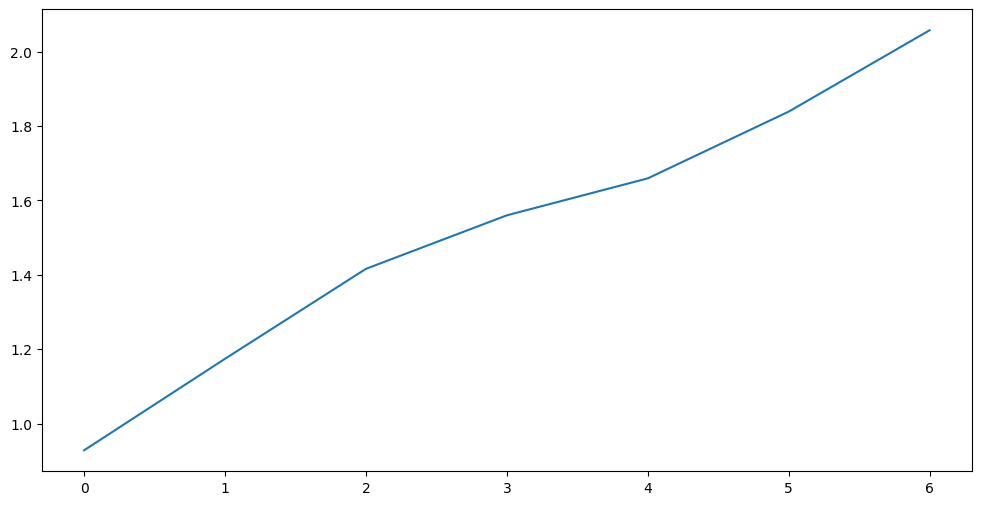

In [385]:
plt.figure(figsize=(12, 6))
# plt.subplot(211)
unwx =np.unwrap(np.angle(row_DC_range_slow_time_m_x_n[0:1200,18]))
# plt.plot(row_DC_range_slow_time_m_x_n[:,18])
plt.plot(unwx[8:15])
# plt.subplot(212)
# plt.plot(new_DC_corrected_range_slow_time_m_x_n[:,18])
plt.show()


In [267]:
unwrap_corrected_range_slow_time_m_x_n = np.zeros_like(corrected_range_slow_time_m_x_n,dtype=float)
for k in range(0,range_bins):
    unwrap_corrected_range_slow_time_m_x_n[:,k] =np.unwrap(np.angle(corrected_range_slow_time_m_x_n[:,k]))

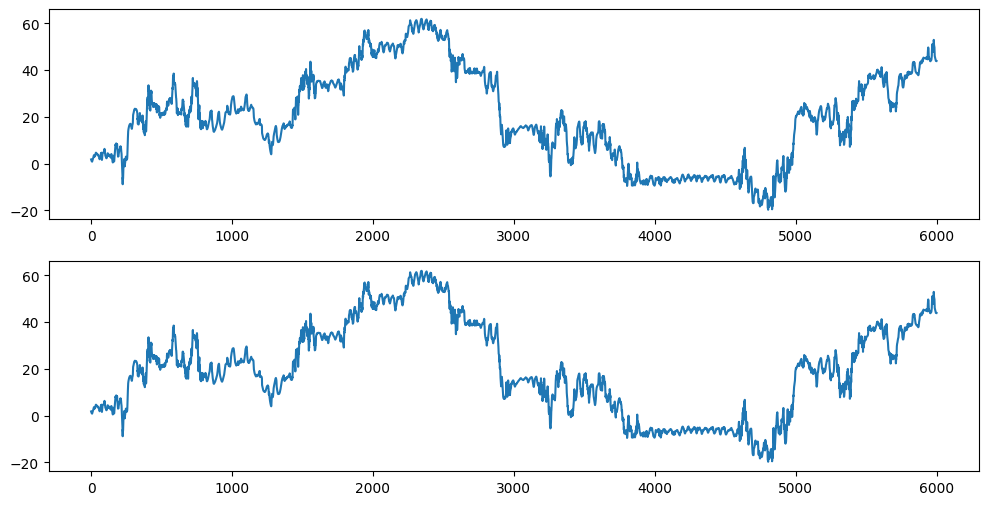

In [351]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(np.unwrap(np.angle(corrected_range_slow_time_m_x_n[:,18])))
plt.subplot(212)
plt.plot(unwrap_corrected_range_slow_time_m_x_n[:,18])
plt.show()

[ 1.83304389+0.j  1.59524745+0.j  1.41899839+0.j ... 43.97639878+0.j
 43.97497464+0.j 43.94023278+0.j]


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


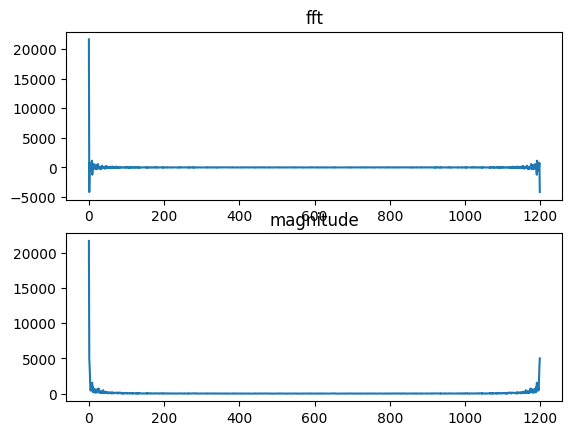

In [242]:
selecte_bin = unwrap_corrected_range_slow_time_m_x_n[:,18]
print(selecte_bin)
plt.subplot(211)
plt.plot(np.fft.fft(selecte_bin[0:1200]))
plt.title("fft")
plt.subplot(212)
plt.plot(np.abs(np.fft.fft(selecte_bin[0:1200])))
plt.title("magnitude")
plt.show()

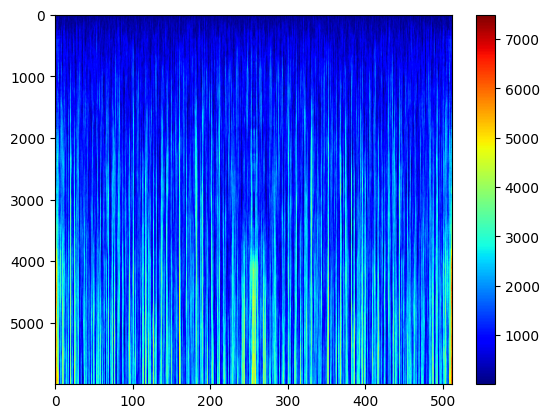

In [269]:
magnitudes = [np.abs(np.fft.fft(unwraps)) for unwraps in unwrap_corrected_range_slow_time_m_x_n]

plt.imshow(magnitudes, cmap='jet', aspect='auto')

plt.colorbar()